In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler import CouplingMap
from qiskit.converters import dag_to_circuit
from qiskit.transpiler.layout import Layout
import numpy as np
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import (
    TrivialLayout,
    BasicSwap,
    ApplyLayout,
    SetLayout,
    SabreLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from qiskit.transpiler.passmanager import PassManager

# from virtual_swap.cns_sabre import CNS_SabreSwap
from virtual_swap.passes.cns_sabre_v2 import CNS_SabreSwap_V2 as CNS_SabreSwap

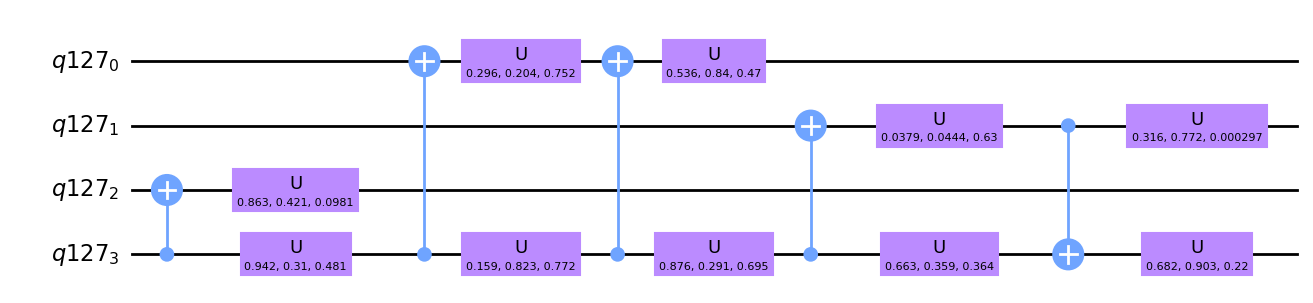

In [188]:
# load a dummy circuit
# generate network of random cnots
n, M = 2, 5
N = n**2
register = QuantumRegister(N)
qc = QuantumCircuit(register)

for _ in range(M):
    # choose 2 random qubits
    qargs = np.random.choice(N, 2, replace=False)
    qc.cx(*qargs)
    qc.u(np.random.rand(), np.random.rand(), np.random.rand(), qargs[0])
    qc.u(np.random.rand(), np.random.rand(), np.random.rand(), qargs[1])
qc.decompose().draw("mpl")

In [189]:
# N =3
# register = QuantumRegister(N)
# qc = QuantumCircuit(register)
# qc.ccx(0,1,2)
# qc = qc.decompose()
# qc.draw("mpl")

In [190]:
# load a dummy coupling map and layout
coupling = CouplingMap.from_line(N)
layout = Layout({q: i for q, i in zip(register, range(N))})

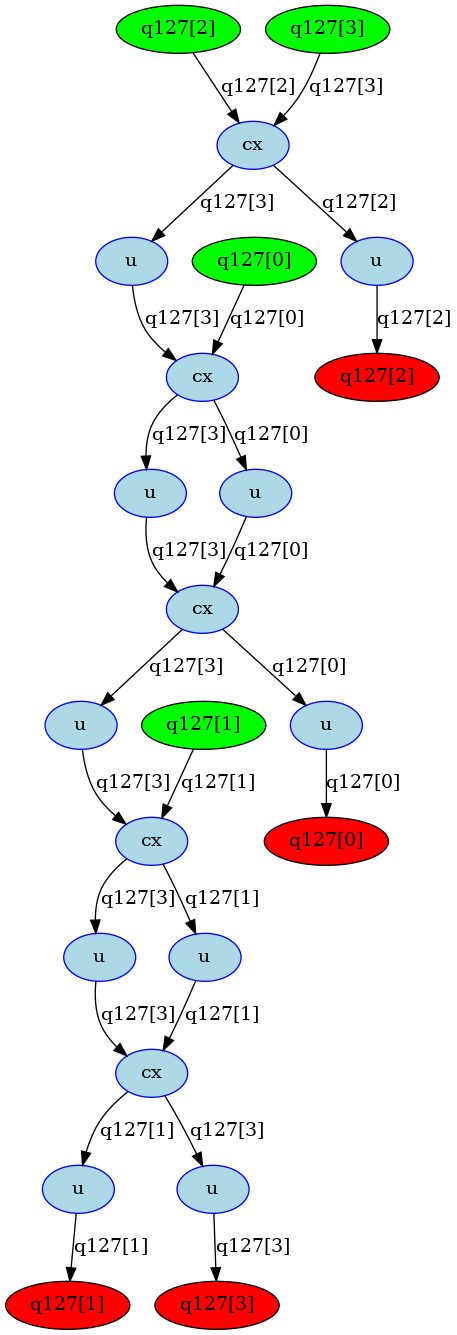

In [191]:
# print DAG
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qc)
dag.draw("mpl")

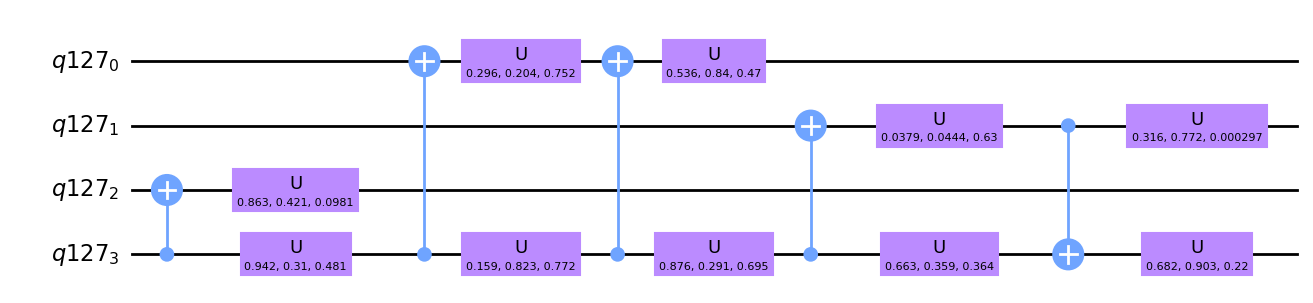

In [192]:
qc.draw("mpl")

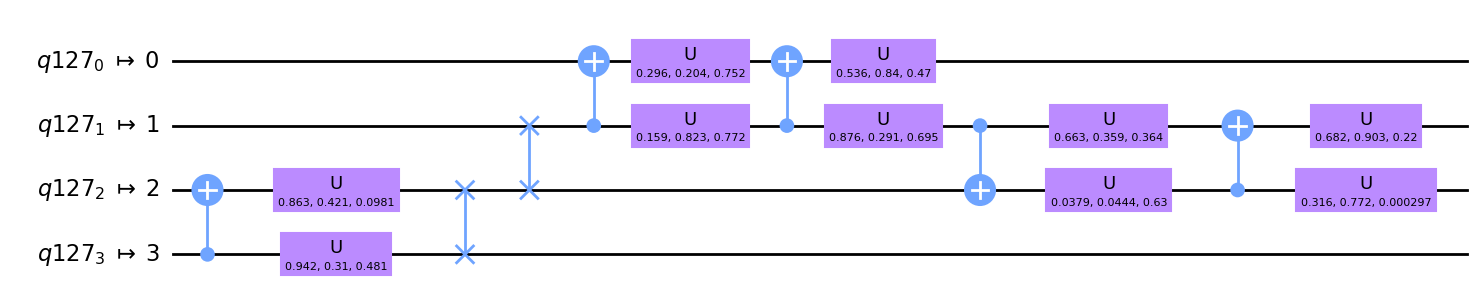

In [193]:
from qiskit import transpile

qiskit_qc = transpile(
    qc, coupling_map=coupling, initial_layout=layout, optimization_level=3
)
qiskit_qc.draw("mpl")

True


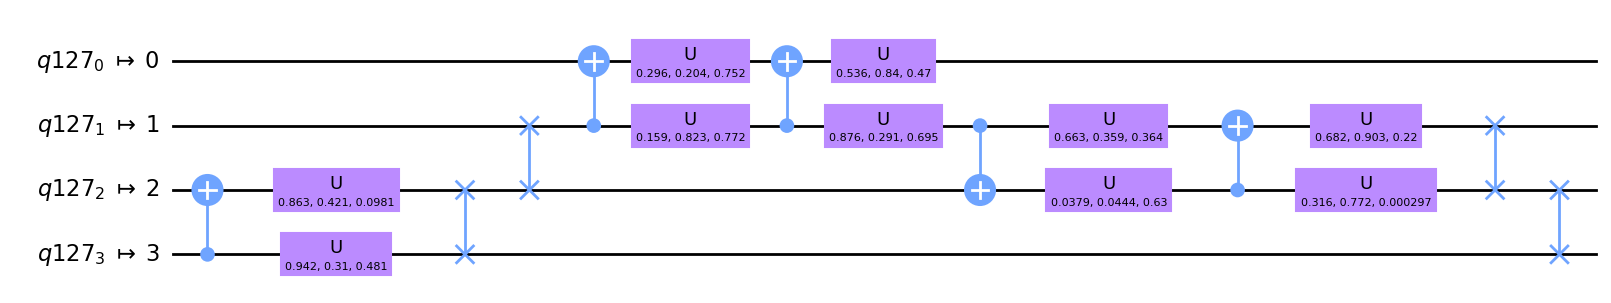

In [194]:
# for every swap gate, append a swap gate to the end of the circuit
# this forces the qubit register ordering to be the same as the input
from qiskit.converters import circuit_to_dag

temp_dag = circuit_to_dag(qiskit_qc)
for node in list(temp_dag.topological_op_nodes())[::-1]:
    if node.name == "swap":
        qiskit_qc.append(node.op, node.qargs)
print(Operator(qiskit_qc).equiv(qc))
qiskit_qc.draw("mpl")

1


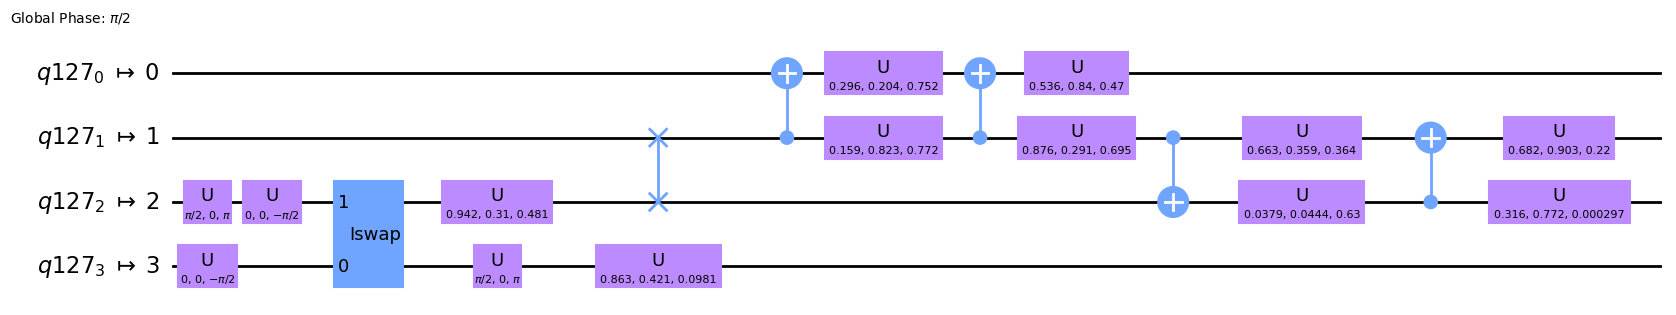

In [195]:
# make sure the old sabre python code works with our new qiskit version
from qiskit.transpiler.passes import Optimize1qGates

pm = PassManager()
pm.append(Unroller(["u", "cx", "iswap", "swap"]))
pm.append(Optimize1qGates(["u", "cx", "iswap", "swap"]))
routing = CNS_SabreSwap(coupling, heuristic="lookahead")
# pm.append(SabreLayout(coupling, routing_pass=routing))
# pm.append(TrivialLayout(coupling))
pm.append(SetLayout(layout))
pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
pm.append(routing)
pm.append(Unroller(["u", "cx", "iswap", "swap"]))
qc_swapped = pm.run(qc)
print(pm.property_set["accept_subs"])
qc_swapped.draw("mpl")

True


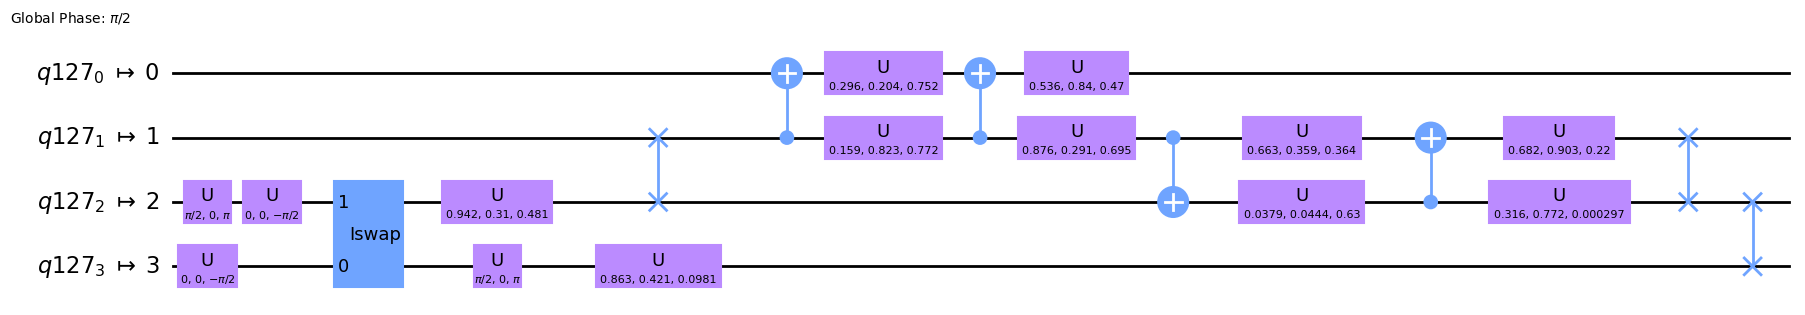

In [196]:
# for every swap gate, append a swap gate to the end of the circuit
# this forces the qubit register ordering to be the same as the input
from qiskit.converters import circuit_to_dag
from qiskit.circuit.library import SwapGate

temp_dag = circuit_to_dag(qc_swapped)
for node in list(temp_dag.topological_op_nodes())[::-1]:
    if node.name == "swap" or node.name == "iswap":
        qc_swapped.append(SwapGate(), node.qargs)
print(Operator(qc_swapped).equiv(qc))
qc_swapped.draw("mpl")

In [197]:
snapshots = pm.property_set["mapped_dag_snaps"]
for snap in snapshots:
    display(snap)

TypeError: 'NoneType' object is not iterable